**Название проекта:**

Определение стоимости автомобилей с пробегом.
____

**Цель исследования:**

Сервис по продаже автомобилей с пробегом «ХХХХ» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Необходимо построить модель для определения стоимости.

***Заказчику важны:***

*    качество предсказания
*    скорость предсказания
*    время обучения

____

**Исходные данные:**

*    В распоряжении есть исторические <a href="https://code.s3.yandex.net/datasets/autos.csv"> данные: </a> технические характеристики, комплектации и цены автомобилей.


***Описание данных:***

Таблица **autos.csv** (исторические данные):

**Признаки:**

*    DateCrawled — дата скачивания анкеты из базы
*    VehicleType — тип автомобильного кузова
*    RegistrationYear — год регистрации автомобиля
*    Gearbox — тип коробки передач
*    Power — мощность (л. с.)
*    Model — модель автомобиля
*    Kilometer — пробег (км)
*    RegistrationMonth — месяц регистрации автомобиля
*    FuelType — тип топлива
*    Brand — марка автомобиля
*    NotRepaired — была машина в ремонте или нет
*    DateCreated — дата создания анкеты
*    NumberOfPictures — количество фотографий автомобиля
*    PostalCode — почтовый индекс владельца анкеты (пользователя)
*    LastSeen — дата последней активности пользователя


**Целевой признак:**

*    Price — цена (евро)

____

**Данное исследование разделим на несколько частей.**

<a href='#link_1'> ***Часть 1. Изучение общей информации и подготовка данных:***</a>

*   Изучение файлов с данными, получение общей информации, загрузка библиотек.
*   Поиск явных дубликатов
*   Нахождение пропусков поиск их причин.
*   Оценка типов данных


<a href='#link_2'> ***Часть 2. Обучение моделей:***</a>

*    <a href='#link_2.1'>2.1 Подбор лучших гиперпараметров и обучение модели RandomForestRegressor.</a>
*    <a href='#link_2.2'>2.2 Подбор лучших гиперпараметров и обучение модели CatBoostRegressor.</a>
*    <a href='#link_2.3'>2.3 Подбор лучших гиперпараметров и обучение модели LGBMRegressor.</a>
*    <a href='#link_2.4'>2.4 Обучение модели LinearRegression.</a>


<a href='#link_3'> ***Часть 3. Анализ моделей.***</a>

<a href='#link_4'> ***Часть 4. Общий вывод:***</a>

<a id='link_1'> </a>
## Откроем файл, изучим и подготовим данные

In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import winsound

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import optuna
import time

from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', '{:,.2f}'.format)

STATE = np.random.RandomState(12345)

In [3]:
def sound():
    '''
    Функция для подачи звука.
    Нужно для сигнализации об окончании выполнения кода.
    '''
    duration = 1000 # миллисекунды
    freq = 440 # Гц
    winsound.Beep(freq, duration)

In [5]:
# Функция для получения первичной информации об исходных данных
def get_info(df):
    '''
    Функция для получения первичной информации об исходных данных:
       - типы данных,
       - количество пропусков,
       - кол-во дубликатов, 
       - характеристики числовых столбцов
    '''
    print(100 * "-")
    print('Общее описание полученных данных:')
    print(100 * "-")
    df.info()
    print(100 * "-")
    print('Описание количественных переменных:')
    print(100 * "-")    
    display(df.describe())
    print(100 * "-")
    print(f'Количество полных дубликатов в таблице = {df.duplicated().sum()}')

In [6]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
get_info(df)

----------------------------------------------------------------------------------------------------
Общее описание полученных данных:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        28321

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


----------------------------------------------------------------------------------------------------
Количество полных дубликатов в таблице = 4


In [8]:
# Проверим строки с полными дубликатами и отсортируем их по зарплате
df[df.duplicated(keep=False)].sort_values(by='Price').head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


In [9]:
# Удалим дубликаты
df = df.drop_duplicates()

In [10]:
# Напишем функция для подсчета пропусков
def missing_data(df):
    '''
    Функция для подсчета пропусков.
    На вход подается DataFrame.
    На выходе получаем таблицу с количеством пропусков в каждом столбце
    и значение доли пропусков по данному столбцу.
    '''
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [11]:
# Проверим количество пропусков путем вызова функции 'missing_data'
missing_col = missing_data(df)
missing_col

,Total,Percent
NotRepaired,71154,0.20
VehicleType,37490,0.11
FuelType,32895,0.09
Gearbox,19833,0.06
Model,19705,0.06
DateCrawled,0,0.00
Price,0,0.00
RegistrationYear,0,0.00
Power,0,0.00
Kilometer,0,0.00


In [12]:
# Найдем и запишем названия столбцов с пропущенными данными. 
missing_col = missing_col[missing_col[missing_col.columns[0]] > 0].index
missing_col

Index(['NotRepaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model'], dtype='object')

In [13]:
# Найдем уникальные значения в столбцах с пропусками. 
for column in missing_col:
    print(f'Уникальные значения столбца "{column}"')
    print(df[column].unique())
    print()

Уникальные значения столбца "NotRepaired"
[nan 'yes' 'no']

Уникальные значения столбца "VehicleType"
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения столбца "FuelType"
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

Уникальные значения столбца "Gearbox"
['manual' 'auto' nan]

Уникальные значения столбца "Model"
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'monde

**Вывод:**

5 столбцов имеют пропуски и их довольно большое количество. Можно заполнить следующим образом:

-    "NotRepaired" - 'unknown'
-    "VehicleType" - проверить есть ли аналогичные автомобили и заполнить, для остальных возьмем существующий 'other'
-    "FuelType" - по другим данным заполнить нет возможности, поэтому возьмем существующий 'other'
-    "Gearbox" - по другим данным заполнить нет возможности, поэтому возьмем существующий 'unknown'
-    "Model" - по другим данным заполнить нет возможности, поэтому возьмем существующий 'other'



In [14]:
# Проверим как заполнено поле 'VehicleType' для одной марки автомобиля.
# Для примера возьмем 'volkswagen' 'golf' и проверим на уникальность значений столбца 'VehicleType'
df[(df['Brand'] == 'volkswagen') & (df['Model'] == 'golf')]['VehicleType'].unique()

array([nan, 'small', 'sedan', 'bus', 'other', 'wagon', 'convertible',
       'coupe', 'suv'], dtype=object)

Мы видим, что один автомобиль имеет разный тип, поэтому заполним все пропуски значением 'other'

In [15]:
df[['NotRepaired', 'Gearbox']] = df[['NotRepaired', 'Gearbox']].fillna('unknown')
df[['FuelType', 'Model', 'VehicleType']] = df[['FuelType', 'Model', 'VehicleType']].fillna('other')

In [16]:
# df.info()

**Проведем исследование столбцов с датой.**

Столбцы с датой как таковые не имеют значение на стоимость, но в сочетании друг с другом эти данные могут быть полезны.

-    Столбцы с датой 'DateCrawled', 'DateCreated', 'LastSeen' имеют тип 'object'. Переведем их м тип даты. 
-    RegistrationYear не имеет влияние на стоимость, но при сочетании с датой создания анкеты можно получить возраст авто на день создания анкеты 'DateCreated'. Поэтому посчитаем возраст авто на день публикации и создадим отдельный столбец 'YearsOld'
-    'LastSeen' сама по себе дата ни о чем не говорит, но в сочетании с датой создания анкеты 'DateCreated' мы можем получить время, предположитель в течении которого проводилась продажа автомобиля. Создадим отдельный столбец 'SellDays'


In [17]:
# Переведем cтолбцы с датой в формат дата-время
dates = ['DateCrawled', 'DateCreated', 'LastSeen']
for day in dates:
    df[day] = pd.to_datetime(df[day], format='%Y-%m-%d %H:%M:%S')

In [18]:
#df.info()

In [19]:
# Проверим информацию по данным дата скачивания анкеты из базы 'DateCrawled'
df['DateCrawled'].describe(datetime_is_numeric=True)

count                           354365
mean     2016-03-21 12:58:09.520460544
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Мы видим, что последняя дата выкачивания информации от 2016-04-07. То есть можно сделать вывод, что год выпуска должен быть не старше 2016 года и месяц выпуска не более мая. Проведем исследование столбца дата регистрации 'RegistrationYear' на выбросы и удалим все значения в выборке которые позже 2016 года. 

In [20]:
# Проверим значения столбца 'RegistrationYear'
df['RegistrationYear'].describe()

count   354,365.00
mean      2,004.23
std          90.23
min       1,000.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       9,999.00
Name: RegistrationYear, dtype: float64

Text(0, 0.5, 'Количество авто, шт')

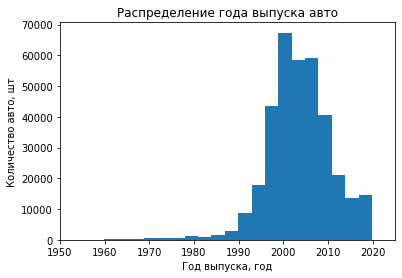

In [21]:
plt.hist(df['RegistrationYear'], bins=3000)
plt.xlim(1950, 2025)
plt.title('Распределение года выпуска авто')
plt.xlabel('Год выпуска, год')
plt.ylabel('Количество авто, шт')

In [22]:
# Найдем значение интерквартильного размаха IQR
irg = df['RegistrationYear'].quantile(.75) - df['RegistrationYear'].quantile(.25)
irg

9.0

In [23]:
# Выведем значение минимального года выпуска автомобиля по методу Q1 - 3*IQR
min_year = df['RegistrationYear'].quantile(.75) - 3 * irg
min_year

1981.0

In [24]:
# Выведем количество отбрасываемых значений
drop_str = ((df['RegistrationYear'] < min_year) | (df['RegistrationYear'] > 2016)).sum()
print(f'Удалению подлежат {drop_str} строк или {drop_str/df.shape[0]:.1%}')

Удалению подлежат 18570 строк или 5.2%


In [25]:
# Очистим столбец 'RegistrationYear' от выбросов
df = df[(df['RegistrationYear'] >= min_year) & (df['RegistrationYear'] < 2017)]
# df.info()

In [26]:
# Создадим стобец с возрастом автомобиля 'YearsOld'
df['YearCreated'] = df['DateCreated'].dt.year
df['YearsOld'] = df['YearCreated'] - df['RegistrationYear']
# df['YearsOld'].describe()

In [27]:
# Создадим столбец 'SellDays' - время продажи автомобиля
df['SellDays'] = df['LastSeen'] - df['DateCreated']
df['SellDays'] = df['SellDays'].dt.days

In [28]:
# df['SellDays'].describe()

Text(0, 0.5, 'Количество авто, шт')

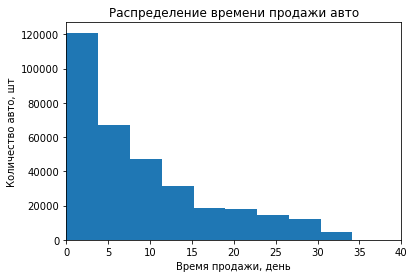

In [29]:
# Построим график распределения времени продажи автомобиля
plt.hist(df['SellDays'], bins=200)
plt.xlim(0, 40)
plt.title('Распределение времени продажи авто')
plt.xlabel('Время продажи, день')
plt.ylabel('Количество авто, шт')

Время продажи автомобиля распределено от 0 до 35 дней. Все что больше 35 дней можно откинуть, как выбросы

In [30]:
# Выведем количество отбрасываемых значений
drop_str = (df['SellDays'] > 35).sum()
print(f'Удалению подлежат {drop_str} строк или {drop_str/df.shape[0]:.1%}')

Удалению подлежат 327 строк или 0.1%


In [31]:
# Откинем выбросы по столбцу 'SellDays'
df = df[df['SellDays'] <= 35]

In [32]:
#df['SellDays'].describe()

In [33]:
# Проверим количество уникальных значений почтового индекса
df['PostalCode'].nunique()

8137

**Некоторые признаки не влияют на нашу модель.**

-    ***DateCrawled*** — дата скачивания анкеты из базы - не важно когда была скачана анкета, это не влияет на ценообразование
-    ***RegistrationMonth*** — месяц регистрации автомобиля - зачастую не важно, в каком месяце был зарегестрирован автомобиль. Это может быть важно только в редких случаях, когда были предновогодние распродажи новых автомобилей например. Но таких вариантов обычно не много. 
-    ***RegistrationYear*** - год регистрации автомобиля (модифицировали в возраст)
-    ***DateCreated*** — дата создания анкеты (модифицировали в возраст)
-    ***NumberOfPictures*** — количество фотографий автомобиля - не влияет на цену. 
-    ***PostalCode*** — почтовый индекс владельца анкеты (пользователя) - теоретически может влиять на стоимость. Но это было бы важно, если был бы не почтовый индекс, а код страны или региона. На данный момент не вижу вариантов объединить индексы. А в чистом виде они не имеют смысла, как числовые значения. 
-    ***LastSeen*** — дата последней активности пользователя - не влияет на цену.

**Удалим данные признаки**

In [34]:
# Удалим не нужные столбцы
drop_col = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 
            'PostalCode', 'LastSeen', 'YearCreated', 'RegistrationYear']
df = df.drop(drop_col, axis=1)

In [35]:
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,YearsOld,SellDays
0,480,other,manual,0,golf,150000,petrol,volkswagen,unknown,23,14
1,18300,coupe,manual,190,other,125000,gasoline,audi,yes,5,14
2,9800,suv,auto,163,grand,125000,gasoline,jeep,unknown,12,22
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15,0
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,8,6


In [36]:
df['Price'].describe()

count   335,468.00
mean      4,446.25
std       4,525.84
min           0.00
25%       1,099.00
50%       2,750.00
75%       6,491.25
max      20,000.00
Name: Price, dtype: float64

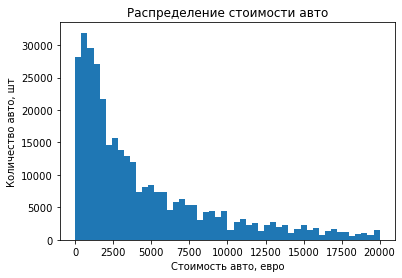

In [37]:
# Посмотрим на распределение стоимости авто
plt.hist(df['Price'], bins=50)
plt.title('Распределение стоимости авто')
plt.xlabel('Стоимость авто, евро')
plt.ylabel('Количество авто, шт')
plt.show()

In [38]:
# Сбросим индексы после удаления выбросов
df = df.reset_index(drop=True)
df

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,YearsOld,SellDays
0,480,other,manual,0,golf,150000,petrol,volkswagen,unknown,23,14
1,18300,coupe,manual,190,other,125000,gasoline,audi,yes,5,14
2,9800,suv,auto,163,grand,125000,gasoline,jeep,unknown,12,22
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15,0
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,8,6
...,...,...,...,...,...,...,...,...,...,...,...
335463,0,other,manual,0,colt,150000,petrol,mitsubishi,yes,11,0
335464,2200,other,unknown,0,other,20000,other,sonstige_autos,unknown,11,23
335465,1199,convertible,auto,101,fortwo,125000,petrol,smart,no,16,6
335466,9200,bus,manual,102,transporter,150000,gasoline,volkswagen,no,20,19


In [39]:
# Найдем все столбцы с категориальными признаками
cat_features = df.dtypes[df.dtypes=="object"].index.values
cat_features

array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired'], dtype=object)

In [40]:
for feature in cat_features:
    print(f'Количество уникальных значений в столбце {feature} = {df[feature].nunique()}')
    print('-' * 60)

Количество уникальных значений в столбце VehicleType = 8
------------------------------------------------------------
Количество уникальных значений в столбце Gearbox = 3
------------------------------------------------------------
Количество уникальных значений в столбце Model = 248
------------------------------------------------------------
Количество уникальных значений в столбце FuelType = 7
------------------------------------------------------------
Количество уникальных значений в столбце Brand = 40
------------------------------------------------------------
Количество уникальных значений в столбце NotRepaired = 3
------------------------------------------------------------


In [41]:
def scaler(data):
    '''
    Масштабирование признаков методом StandardScaler
    '''
    scaler = StandardScaler()
    return scaler.fit_transform(data) 

In [42]:
def cat_to_num_ohe(data, col):
    '''
    Прямое кодирование
    Функция конвертирует признаки методом One-Hot Encoding, OHE    
    '''
    data_ohe = data[col]
    data = data.drop(col, axis=1)
    data_ohe = pd.get_dummies(data_ohe, drop_first=True)
    return pd.concat([data_ohe, data], axis=1)

In [47]:
def cat_to_num_ordinal(data, col):
    '''
    Порядковое кодирование
    Функция конвертирует признаки методом OrdinalEncoder
    '''    
    encoder = OrdinalEncoder()
    data[col] = pd.DataFrame(encoder.fit_transform(data[col]))
    return data

In [45]:
# Конвертируем часть признаков методом OHE
df_num = cat_to_num_ohe(df, ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'])

In [48]:
# Конвертируем остальную часть признаков методом OrdinalEncoder
df_num = cat_to_num_ordinal(df_num, ['Model', 'Brand'])

In [49]:
df_num.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,FuelType_electric,...,FuelType_petrol,NotRepaired_unknown,NotRepaired_yes,Price,Power,Model,Kilometer,Brand,YearsOld,SellDays
0,0,0,1,0,0,0,0,1,0,0,...,1,1,0,480,0,116.00,150000,38.00,23,14
1,0,1,0,0,0,0,0,1,0,0,...,0,0,1,18300,190,166.00,125000,1.00,5,14
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,9800,163,117.00,125000,14.00,12,22
3,0,0,0,0,1,0,0,1,0,0,...,1,0,0,1500,75,116.00,150000,38.00,15,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,3600,69,101.00,90000,31.00,8,6


**Произведем разбиение выборки на тестовую и обучающую.**

In [46]:
# Напишем функцию для разбиения выборки на обучающую и валидационную
def data_split(data, target_name, fraction=0.25):
    
    '''
    Функция для разбиения на признаки и целевой признак. 
    На вход подается выборка и соотношение, на которое нужно разбить (по умолчанию 25%).
    На выходе выдает четыре части:
    features_train, features_test - признаки для обучения и тестирования
    target_train, target_test - целевой признак для обучения и тестирования
    '''
    
    # Разобьем данные на features и target
    features = data.drop(target_name, axis=1)
    target = data[target_name]
    
    # Разобьем данные признаки и целевой признак на обучающую и тестовую выборки 
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, 
        test_size=fraction, 
        random_state=STATE
    )
    return features_train, features_test, target_train, target_test

***Числовые признаки***

In [47]:
# Разобьем выборку с числовыми признаками на обучающую и тестовую выборки
features_train_num, features_test_num, target_train_num, target_test_num = data_split(df_num, 'Price', fraction=0.25)

In [48]:
# Масштабируем данные в столбце 'Kilometer'
features_train_num['Kilometer'] = scaler(features_train_num[['Kilometer']])
features_test_num['Kilometer'] = scaler(features_test_num[['Kilometer']])

***Признаки с категориальными столбцами***

In [49]:
# Преобразуем категориальные признаки в тип 'category'
df[cat_features] = df[cat_features].astype('category')

In [50]:
# Разобьем выборку с категориальными признаками на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = data_split(df, 'Price', fraction=0.25)

In [51]:
# Масштабируем данные в столбце 'Kilometer'
features_train['Kilometer'] = scaler(features_train[['Kilometer']])
features_test['Kilometer'] = scaler(features_test[['Kilometer']])

**Вывод по изучению и подготовке данных**

*    Загрузил и изучил информацию. 
*    Обнаружены 4 полных дубликата. Удалил.
*    Обнаружены пропуски данных в стобцах 'NotRepaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model'. В результате изучения заполнил значениями 'other' и 'unknown'.
*    Обнаружены выбросы и неадекватные данные в столбце 'RegistrationYear'. Удалено 5-6% строк
*    На основе категориальных данных в стобцах 'DateCrawled', 'DateCreated', 'LastSeen' и числовых данных столбца 'YearCreated' созданы новые 2 числовых столбца YearsOld и SellDays.
*    Удалены лишние столбцы признаков
*    Конвертировал категориальные признаки. Brand и Model методом OrdinalEncoder, а остальные методом OHE
*    Разбил данные на тестовую выборку и обучающую.


Итого получили два комплекта данных для разных моделей:

*    только числовые
*    числовые и категориальные


<a id='link_2'> </a>
## Обучим модели

In [253]:
def print_result(result, params = 0):
    '''
    Функция выводит на печать результаты работы модели
    result - словарь(имя модели, время обучения, Время предсказания, RMSE)
    params - гиперпараметры модели
    '''
    print('-' * 100)
    print(f'Для модели {result["model"]}')
    print(f'Гиперпараметры: {params}')
    print(f'RMSE = {result["rmse"]:.0f}')
    print(f'Время обучения: {result["learning_time"]:0.1f} секунд')
    print(f'Время предсказания: {result["prediction_time"]:0.1f} секунд')
    print('-' * 100)

In [254]:
def optuna_hyper(name, objective):
    
    '''
    Подбор гиперпараметров OPTUNA
    На вход подается:
        name - название модели, например name=RandomForestRegressor
        objective - имя функции нужных входных параметров, например objective=objective_rfr
    '''
    # Add t0 - start time
    t0 = time.perf_counter()
    
    num_trials = 7  # more is better especially if num param is high and param range is also high.
    
    study = optuna.create_study(study_name=name, direction='maximize')
    study.optimize(objective, n_trials=num_trials) #, timeout=800)
    
    # Show the best params and score value
    print(f'best params: {study.best_params}')
    print('RMSE = {:.0f}'.format((-study.best_value) ** 0.5))
    
    # Show worktime
    print(f'elapsed time: {time.perf_counter() - t0:0.1f}s')
    
    return study.best_params

<a id='link_2.1'> </a>

### 2.1 Подбор лучших гиперпараметров и обучение модели RandomForestRegressor

In [255]:
# Напишем функцию для модели RandomForestRegressor

def model_random_forest(features_train, features_test, target_train, target_test, params):
    
    """
    Функция обучает модель по методу RandomForestRegressor (Случайный лес).
    На вход подается обучающий набор данных features_train, target_train.
    Также на вход подаются или валидационный набор данных features_valid, target_valid,
    или тестировочный набор данных features_test, target_test.
    
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    
    model = RandomForestRegressor(**params, random_state=STATE) 
    
    # Обучение модели
    model.fit(features_train, target_train)
    
    t1 = time.perf_counter()
    
    # Получение предсказаний
    prediction = model.predict(features_test)
    
    t2 = time.perf_counter()
    
    # Расчет RMSE
    rmse = mean_squared_error(target_test, prediction, squared=False)
    
    result = {'model': 'RandomForestRegressor', 'learning_time': t1-t0, 'prediction_time': t2-t1, 'rmse': rmse}
    
    print_result(result, params)
    
    return result, prediction

In [256]:
def objective_rfr(trial):
    '''
    RandomForestRegressor objective для OPTUNA
    '''
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 20, 150), 
        'max_depth': trial.suggest_int("max_depth", 5, 13),
        'min_samples_split': trial.suggest_int("min_samples_split", 5, 13),
#         'min_samples_leaf': trial.suggest_int("min_samples_leaf", 5, 7),
#         'max_features': trial.suggest_categorical("max_features", ["auto", "sqrt"]),
#         'bootstrap': True,
        'random_state': STATE
    }
       
    clf = RandomForestRegressor(**param)
    
    return cross_val_score(clf, features, target, n_jobs=-1, cv=3, scoring = 'neg_mean_squared_error').mean()

In [257]:
# Обозначим данные для функции подбора гиперпараметров features и target
features = features_train_num
target = target_train_num

In [258]:
# Подберем гиперпараметры для модели RandomForestRegressor
best_params_rfr = optuna_hyper(name='RFRegressor', objective=objective_rfr)
# sound()

[I 2022-05-03 15:44:12,560] A new study created in memory with name: RFRegressor
[I 2022-05-03 15:44:45,002] Trial 0 finished with value: -4707622.978950816 and parameters: {'n_estimators': 45, 'max_depth': 7, 'min_samples_split': 13}. Best is trial 0 with value: -4707622.978950816.
[I 2022-05-03 15:47:15,396] Trial 1 finished with value: -3135357.763005994 and parameters: {'n_estimators': 150, 'max_depth': 13, 'min_samples_split': 13}. Best is trial 1 with value: -3135357.763005994.
[I 2022-05-03 15:47:28,257] Trial 2 finished with value: -4735259.008206309 and parameters: {'n_estimators': 20, 'max_depth': 7, 'min_samples_split': 7}. Best is trial 1 with value: -3135357.763005994.
[I 2022-05-03 15:47:43,084] Trial 3 finished with value: -4343685.6959336735 and parameters: {'n_estimators': 21, 'max_depth': 8, 'min_samples_split': 13}. Best is trial 1 with value: -3135357.763005994.
[I 2022-05-03 15:48:26,682] Trial 4 finished with value: -3152368.5404685065 and parameters: {'n_estimato

best params: {'n_estimators': 150, 'max_depth': 13, 'min_samples_split': 13}
RMSE = 1771
elapsed time: 407.8s


In [259]:
# Обучим модель RandomForestRegressor на лучших параметрах
result_rfr, prediction_rfr = model_random_forest(
    features_train_num, features_test_num, 
    target_train_num, target_test_num,
    best_params_rfr)

----------------------------------------------------------------------------------------------------
Для модели RandomForestRegressor
Гиперпараметры: {'n_estimators': 150, 'max_depth': 13, 'min_samples_split': 13}
RMSE = 1763
Время обучения: 141.6 секунд
Время предсказания: 1.9 секунд
----------------------------------------------------------------------------------------------------


<a id='link_2.2'> </a>

### Подбор лучших гиперпараметров и обучение модели CatBoostRegressor

In [260]:
# Напишем функцию для модели CatBoostRegressor

def model_catboost_regressor(features_train, features_test, target_train, target_test, params, cat_features):
    
    """
    Функция обучает модель по методу CatBoostRegressor.
    На вход подается обучающий набор данных features_train, target_train.
    Также на вход подаются или валидационный набор данных features_valid, target_valid,
    или тестировочный набор данных features_test, target_test.
    
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    
    model = CatBoostRegressor(**params, cat_features=cat_features, loss_function='RMSE')
    
    # Обучение модели
    model.fit(features_train, target_train)
    
    t1 = time.perf_counter()
    
    # Получение предсказаний
    prediction = model.predict(features_test)
    
    t2 = time.perf_counter()
    
    # Расчет RMSE
    rmse = mean_squared_error(target_test, prediction, squared=False)
    
    # Сбор результатов в словарь
    result = {'model': 'CatBoostRegressor', 'learning_time': t1-t0, 'prediction_time': t2-t1, 'rmse': rmse}
    
    # Печать результатов при помощи функции
    print_result(result, params)
    
    return result, prediction

In [261]:
def objective_cbr(trial):
    '''
    CatBoostRegressor objective for OPTUNA

    '''
    param = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.6),
        'depth': trial.suggest_int("depth", 5, 13),      
#         'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 5, 13),
#         'eval_metric': "RMSE",
        'cat_features': cat_features
    }
       
    clf = CatBoostRegressor(**param)    
    
    return cross_val_score(clf, features, target, n_jobs=-1, cv=3, scoring = 'neg_mean_squared_error').mean()

In [262]:
# Обозначим данные для функции подбора гиперпараметров features и target
features = features_train
target = target_train

In [263]:
# Подберем гиперпараметры для модели CatBoostRegressor
best_params_cbr = optuna_hyper(name='CBRegressor', objective=objective_cbr)
# sound()

[I 2022-05-03 15:53:24,335] A new study created in memory with name: CBRegressor
[I 2022-05-03 15:54:13,219] Trial 0 finished with value: -2712901.0573389013 and parameters: {'iterations': 107, 'learning_rate': 0.15185803095703, 'depth': 11}. Best is trial 0 with value: -2712901.0573389013.
[I 2022-05-03 16:02:26,404] Trial 1 finished with value: -2565511.2392855077 and parameters: {'iterations': 754, 'learning_rate': 0.20052608561799531, 'depth': 7}. Best is trial 1 with value: -2565511.2392855077.
[I 2022-05-03 16:09:30,628] Trial 2 finished with value: -2608740.426072009 and parameters: {'iterations': 639, 'learning_rate': 0.42699291079055063, 'depth': 7}. Best is trial 1 with value: -2565511.2392855077.
[I 2022-05-03 16:11:47,323] Trial 3 finished with value: -2608542.5380338468 and parameters: {'iterations': 181, 'learning_rate': 0.19930722664484626, 'depth': 13}. Best is trial 1 with value: -2565511.2392855077.
[I 2022-05-03 16:12:21,720] Trial 4 finished with value: -3129836.905

best params: {'iterations': 754, 'learning_rate': 0.2264104382220606, 'depth': 11}
RMSE = 1601
elapsed time: 2771.9s


In [264]:
# Обучим модель CatBoostRegressor на лучших параметрах
result_cbr, prediction_cbr = model_catboost_regressor(
    features_train, features_test, 
    target_train, target_test,
    best_params_cbr,
    cat_features = cat_features)

0:	learn: 3786.3283429	total: 764ms	remaining: 9m 35s
1:	learn: 3250.3361558	total: 1.48s	remaining: 9m 15s
2:	learn: 2857.7699508	total: 2.2s	remaining: 9m 9s
3:	learn: 2559.6044120	total: 2.84s	remaining: 8m 52s
4:	learn: 2352.8472296	total: 3.58s	remaining: 8m 55s
5:	learn: 2201.5413853	total: 4.24s	remaining: 8m 48s
6:	learn: 2095.0204782	total: 4.82s	remaining: 8m 34s
7:	learn: 2019.8512131	total: 5.58s	remaining: 8m 40s
8:	learn: 1952.2422327	total: 6.34s	remaining: 8m 44s
9:	learn: 1909.7264648	total: 7.01s	remaining: 8m 41s
10:	learn: 1874.9019099	total: 7.7s	remaining: 8m 40s
11:	learn: 1838.9041017	total: 8.44s	remaining: 8m 41s
12:	learn: 1810.8624495	total: 9.15s	remaining: 8m 41s
13:	learn: 1792.0768047	total: 9.94s	remaining: 8m 45s
14:	learn: 1771.8856856	total: 10.7s	remaining: 8m 46s
15:	learn: 1759.8536399	total: 11.4s	remaining: 8m 45s
16:	learn: 1746.9541304	total: 12.1s	remaining: 8m 45s
17:	learn: 1738.2012327	total: 12.8s	remaining: 8m 44s
18:	learn: 1731.4887784

<a id='link_2.3'> </a>

### Подбор лучших гиперпараметров и обучение модели LGBMRegressor

In [265]:
# Напишем функцию для модели LGBMRegressor

def model_lgbm_regressor(features_train, features_test, target_train, target_test, params):
    
    """
    Функция обучает модель по методу LGBMRegressor.
    На вход подается обучающий набор данных features_train, target_train.
    Также на вход подаются или валидационный набор данных features_valid, target_valid,
    или тестировочный набор данных features_test, target_test.
    
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    
    model = LGBMRegressor(**params, random_state=STATE)
    
    # Обучение модели
    model.fit(features_train, target_train)
    
    t1 = time.perf_counter()
    
    # Получение предсказаний
    prediction = model.predict(features_test)
    
    t2 = time.perf_counter()
    
    # Расчет RMSE
    rmse = mean_squared_error(target_test, prediction, squared=False)

    # Сбор результатов в словарь
    result = {'model': 'LGBMRegressor', 'learning_time': t1-t0, 'prediction_time': t2-t1, 'rmse': rmse}
    
    # Печать результатов при помощи функции    
    print_result(result, params)    
   
    return result, prediction

In [266]:
def objective_lgbmr(trial):
    '''
    LGBMRegressor objective for OPTUNA
    '''
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 20, 150),
        'learning_rate': trial.suggest_float("learning_rate", 0.1, 0.6),
        'max_depth': trial.suggest_int("max_depth", 5, 13),
        'random_state': STATE
    }
       
    clf = LGBMRegressor(**param)    
    
    return cross_val_score(clf, features, target, n_jobs=-1, cv=3, scoring = 'neg_mean_squared_error').mean()

In [267]:
# Обозначим данные для функции подбора гиперпараметров features и target
features = features_train
target = target_train

In [268]:
# Подберем гиперпараметры для модели LGBMRegressor
best_params_lgbmr = optuna_hyper(name='LGBMRegressor', objective=objective_lgbmr)
# sound()

[I 2022-05-03 16:49:43,086] A new study created in memory with name: LGBMRegressor
[I 2022-05-03 16:49:52,845] Trial 0 finished with value: -2690103.7930478677 and parameters: {'n_estimators': 127, 'learning_rate': 0.393298956886995, 'max_depth': 13}. Best is trial 0 with value: -2690103.7930478677.
[I 2022-05-03 16:50:01,326] Trial 1 finished with value: -2765075.982957229 and parameters: {'n_estimators': 113, 'learning_rate': 0.5433744290374865, 'max_depth': 13}. Best is trial 0 with value: -2690103.7930478677.
[I 2022-05-03 16:50:04,951] Trial 2 finished with value: -2742128.4414769704 and parameters: {'n_estimators': 63, 'learning_rate': 0.2517416895676081, 'max_depth': 6}. Best is trial 0 with value: -2690103.7930478677.
[I 2022-05-03 16:50:09,062] Trial 3 finished with value: -2635338.619188965 and parameters: {'n_estimators': 127, 'learning_rate': 0.2389847980459158, 'max_depth': 9}. Best is trial 3 with value: -2635338.619188965.
[I 2022-05-03 16:50:12,584] Trial 4 finished wit

best params: {'n_estimators': 127, 'learning_rate': 0.2389847980459158, 'max_depth': 9}
RMSE = 1623
elapsed time: 35.6s


In [269]:
# Обучим модель LGBMRegressor на лучших параметрах
result_lgbmr, prediction_lgbmr = model_lgbm_regressor(
    features_train_num, features_test_num, 
    target_train_num, target_test_num,    
    best_params_lgbmr)

----------------------------------------------------------------------------------------------------
Для модели LGBMRegressor
Гиперпараметры: {'n_estimators': 127, 'learning_rate': 0.2389847980459158, 'max_depth': 9}
RMSE = 1652
Время обучения: 1.5 секунд
Время предсказания: 0.3 секунд
----------------------------------------------------------------------------------------------------


<a id='link_2.4'> </a>

### Обучение модели LinearRegression

In [328]:
# Напишем функцию для модели LinearRegression

def model_linear_regression(features_train, features_test, target_train, target_test):
        
    """
    Функция обучает модель по методу LinearRegression.
    На вход подается обучающий набор данных features_train, target_train.
    Также на вход подаются или валидационный набор данных features_valid, target_valid,
    или тестировочный набор данных features_test, target_test.
    На выходе функция выдает предсказания и RMSE модели.
    """
    t0 = time.perf_counter()
       
    model = LinearRegression()
    
    # Обучение модели
    model.fit(features_train, target_train)
    
    t1 = time.perf_counter()
    
    # Получение предсказаний
    prediction = model.predict(features_test)
    
    t2 = time.perf_counter()
    
    # Расчет RMSE
    rmse = mean_squared_error(target_test, prediction, squared=False)
    
    # Сбор результатов в словарь
    result = {'model': 'LinearRegression', 'learning_time': t1-t0, 'prediction_time': t2-t1, 'rmse': rmse}
    
    # Печать результатов при помощи функции
    print_result(result)
    
    return result, prediction

In [329]:
# Обучим модель LinearRegression на лучших параметрах
result_lr, prediction_lr = model_linear_regression(
    features_train_num, features_test_num, 
    target_train_num, target_test_num)

----------------------------------------------------------------------------------------------------
Для модели LinearRegression
Гиперпараметры: 0
RMSE = 3010
Время обучения: 0.3 секунд
Время предсказания: 0.0 секунд
----------------------------------------------------------------------------------------------------


<a id='link_3'> </a>
## Проанализируем модели

In [272]:
# для модели RandomForestRegressor
print_result(result_rfr, best_params_rfr)

# для модели CatBoostRegressor
print_result(result_cbr, best_params_cbr)

# для модели LGBMRegressor
print_result(result_lgbmr, best_params_lgbmr)

# для модели LinearRegression
print_result(result_lr)

----------------------------------------------------------------------------------------------------
Для модели RandomForestRegressor
Гиперпараметры: {'n_estimators': 150, 'max_depth': 13, 'min_samples_split': 13}
RMSE = 1763
Время обучения: 141.6 секунд
Время предсказания: 1.9 секунд
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Для модели CatBoostRegressor
Гиперпараметры: {'iterations': 754, 'learning_rate': 0.2264104382220606, 'depth': 11}
RMSE = 1596
Время обучения: 605.5 секунд
Время предсказания: 1.2 секунд
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Для модели LGBMRegressor
Гиперпараметры: {'n_estimators': 127, 'learning_rate': 0.2389847980459158, 'max_depth': 9}
RMSE = 

In [273]:
# sound()

In [322]:
# Создадим словарь с готовыми ключами и пустыми списками в нем
results = {i: [] for i in result_rfr.keys()}
results

{'model': [], 'learning_time': [], 'prediction_time': [], 'rmse': []}

In [323]:
# Соберем все результаты в словарь 'results'
for result in [result_rfr, result_cbr, result_lgbmr]:
    for key, value in result.items():
        results[key].append(value)
results

{'model': ['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
 'learning_time': [141.63154239999858, 605.5489715000003, 1.5059979999969073],
 'prediction_time': [1.9434480999989319,
  1.2033566999998584,
  0.27145350000137114],
 'rmse': [1763.2180517937868, 1595.9672388738043, 1652.1484991690966]}

In [324]:
# Соберем результаты в таблицу
results = pd.DataFrame(results)
results

,model,learning_time,prediction_time,rmse
0,RandomForestRegressor,141.63,1.94,"1,763.22"
1,CatBoostRegressor,605.55,1.20,"1,595.97"
2,LGBMRegressor,1.51,0.27,"1,652.15"


In [325]:
# Добавим столбец 'rmse delta' - разница показаний RMSE с лучшим результатом
results['rmse delta'] = results['rmse'] / results['rmse'].min() - 1
results

,model,learning_time,prediction_time,rmse,rmse delta
0,RandomForestRegressor,141.63,1.94,"1,763.22",0.10
1,CatBoostRegressor,605.55,1.20,"1,595.97",0.00
2,LGBMRegressor,1.51,0.27,"1,652.15",0.04


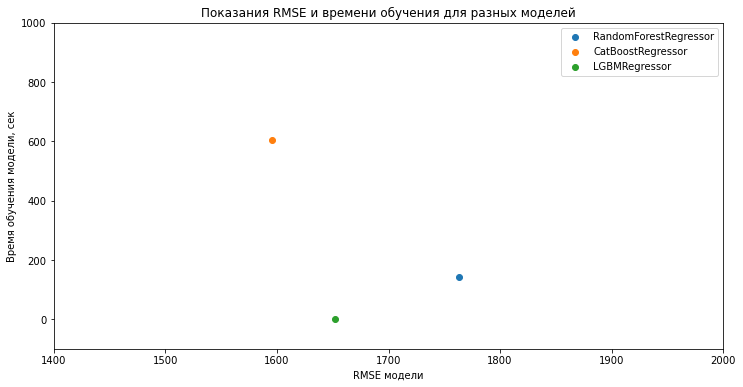

In [327]:
# Построим результаты RMSE и времени обучения моделей на одном графике
fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(results)):
    ax.scatter(results.loc[i, 'rmse'], results.loc[i, 'learning_time'], label=results.loc[i, 'model'], marker='o')

plt.xlim(1400, 2000)
plt.ylim(-100, 1000)
ax.set_xlabel('RMSE модели')
ax.set_ylabel('Время обучения модели, сек')
ax.set_title('Показания RMSE и времени обучения для разных моделей')
ax.legend()

<a id='link_4'> </a>
## Общий вывод:

В результате подбора гиперпараметров и обучения моделей мы видим:

-    Самый низкий RMSE у модели CatBoostRegressor. При этом у этой модели самое высокое время обучения. Отличает данную модель от других то, что она работает с категориальными признаками.
-    Далее по RMSE идет модель LGBMRegressor. При этом RMSE выше всего на 4%, а вот время обучения ниже в 400 раз.
-    На третьем месте по RMSE идет модель RandomForestRegressor, показатель которой выше на 10% и время обучения ниже в 4 раза.
    
Учитывая время обучения и метрику, а также то, что стоимость автомобиля не критичный параметр и нужен в основном для оценки уровня стоимости того или иного автомобиля, рекомендуется использовать модель LGBMRegressor